# Analyse ConvLSTM2D because a bit special

In [2]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import yaml
import datetime

from src.utils import tardisml_utils
from src.data_preparation import load_data
import netCDF4 as nc4

In [3]:
rootdir = tardisml_utils.get_rootdir()

In [4]:
pca_dir = 'Leo/results/pca_i100-550_j300-629/'

In [5]:
# ConvLSTM2D_H
ncpath = 'Leo/results/C2D_230308-185753/'
nc_name = 'ConvLSTM2D'
ncfile = 'ypred_ConvLSTM2D_H_epochs10_6feat.nc'

nc = nc4.Dataset(f'{rootdir}{ncpath}ml/{ncfile}', mode='r')
c2d_sit = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['sit_pred']
chrono = pd.DataFrame({'date':pd.to_datetime(c2d_sit['time'].to_numpy())})

In [6]:
# Import Topaz 4

target_field = 'sithick'
filename = os.path.join(rootdir,pca_dir,f"{target_field}_TOPAZ4b_2011_2019.nc")

sit_true, chrono_true = load_data.load_nc(filename, f'{target_field}', X_only=True)

In [7]:
sit_true

<xarray.DataArray 'sithick' (time: 3014, y: 329, x: 450)>
[446222700 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2011-10-01 2011-10-02 ... 2019-12-31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5
Attributes:
    cell_methods:   area: mean where sea_ice
    grid_mapping:   stereographic
    standard_name:  sea_ice_thickness
    units:          m

In [8]:
# clean c2d_sit: nan on land and remove <0 values

sit_tmp = c2d_sit.where(c2d_sit>0, 0)
sit_ml = sit_tmp.where(~np.isnan(sit_true))

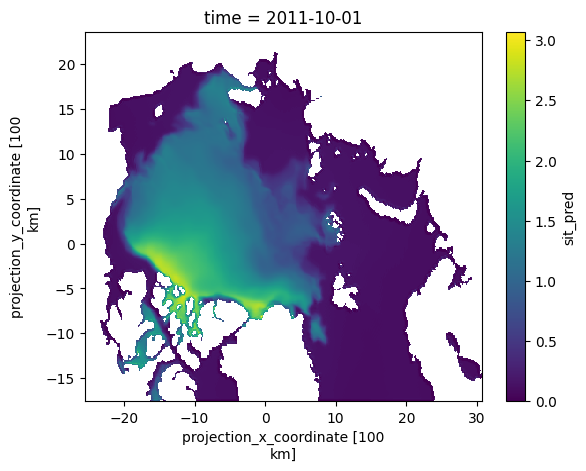

In [9]:
sit_ml.isel(time=0).plot()

In [10]:
# cut time serie
_, [sit_true] = load_data.trunc_da_to_chrono(chrono, chrono_true, [sit_true])


In [47]:
sit_true_mean = sit_true.mean(('x','y'))

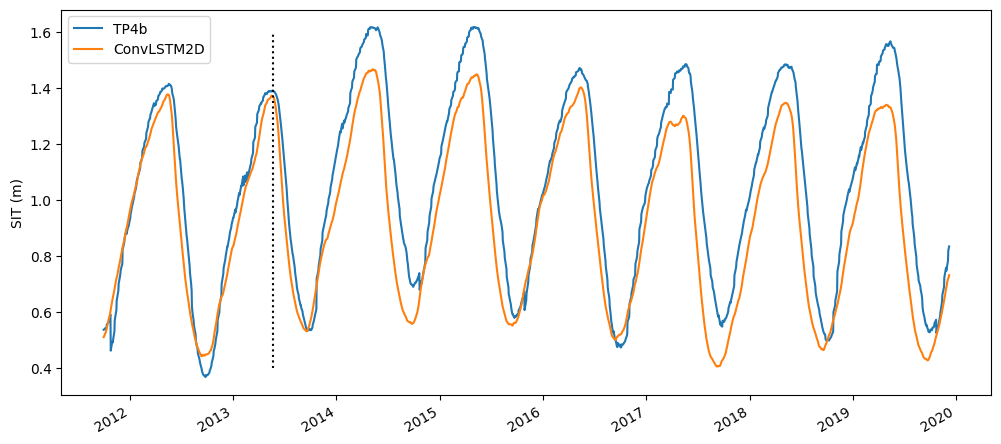

In [77]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,5))

sit_true_mean.plot(label='TP4b')
# sit_ml.mean(('x','y')).plot()
# real_sit.mean(('x','y')).plot(label='sit real')
plt.plot(chrono, msit, label='ConvLSTM2D')
ax.plot([chrono.iloc[599]]*2, [0.4,1.6],ls=':', c='k')

ax.set_xlabel('')
ax.set_ylabel('SIT (m)')
plt.legend()

In [ ]:
# change prediction because fucked up the order
# ntest, nval, ntrain
#(599, 448, 1943)

In [ ]:
sit_train = sit_ml.isel(time=slice(None,1943))
sit_val = sit_ml.isel(time=slice(1943,1943+448))
sit_test = sit_ml.isel(time=slice(1943+448,1943+448+599))

real_sit = xr.concat((sit_test, sit_val, sit_train), dim='time')

msit = real_sit.mean(('x','y')).data

In [57]:
sit_ml = xr.DataArray(data=real_sit.data, 
                        dims=['time','y','x'], 
                        coords={'time':chrono[:].squeeze(),'y':real_sit.y,'x':real_sit.x},
                        name='sit_pred')

In [58]:
bias=(sit_ml - sit_true).mean(('x','y'))

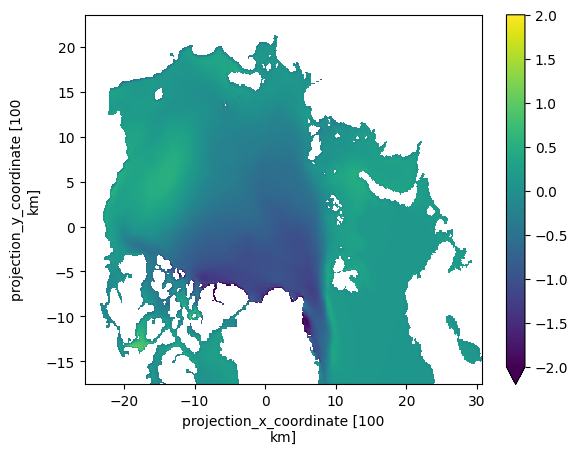

In [60]:
(sit_ml - sit_true).mean(('time')).plot(vmin=-2, vmax=2)

In [61]:
rmse = np.sqrt((np.square(sit_ml - sit_true)).mean(dim=('x','y')))

In [62]:
corr = xr.corr(sit_ml, sit_true, dim=('y','x'))

In [63]:
ntest=600

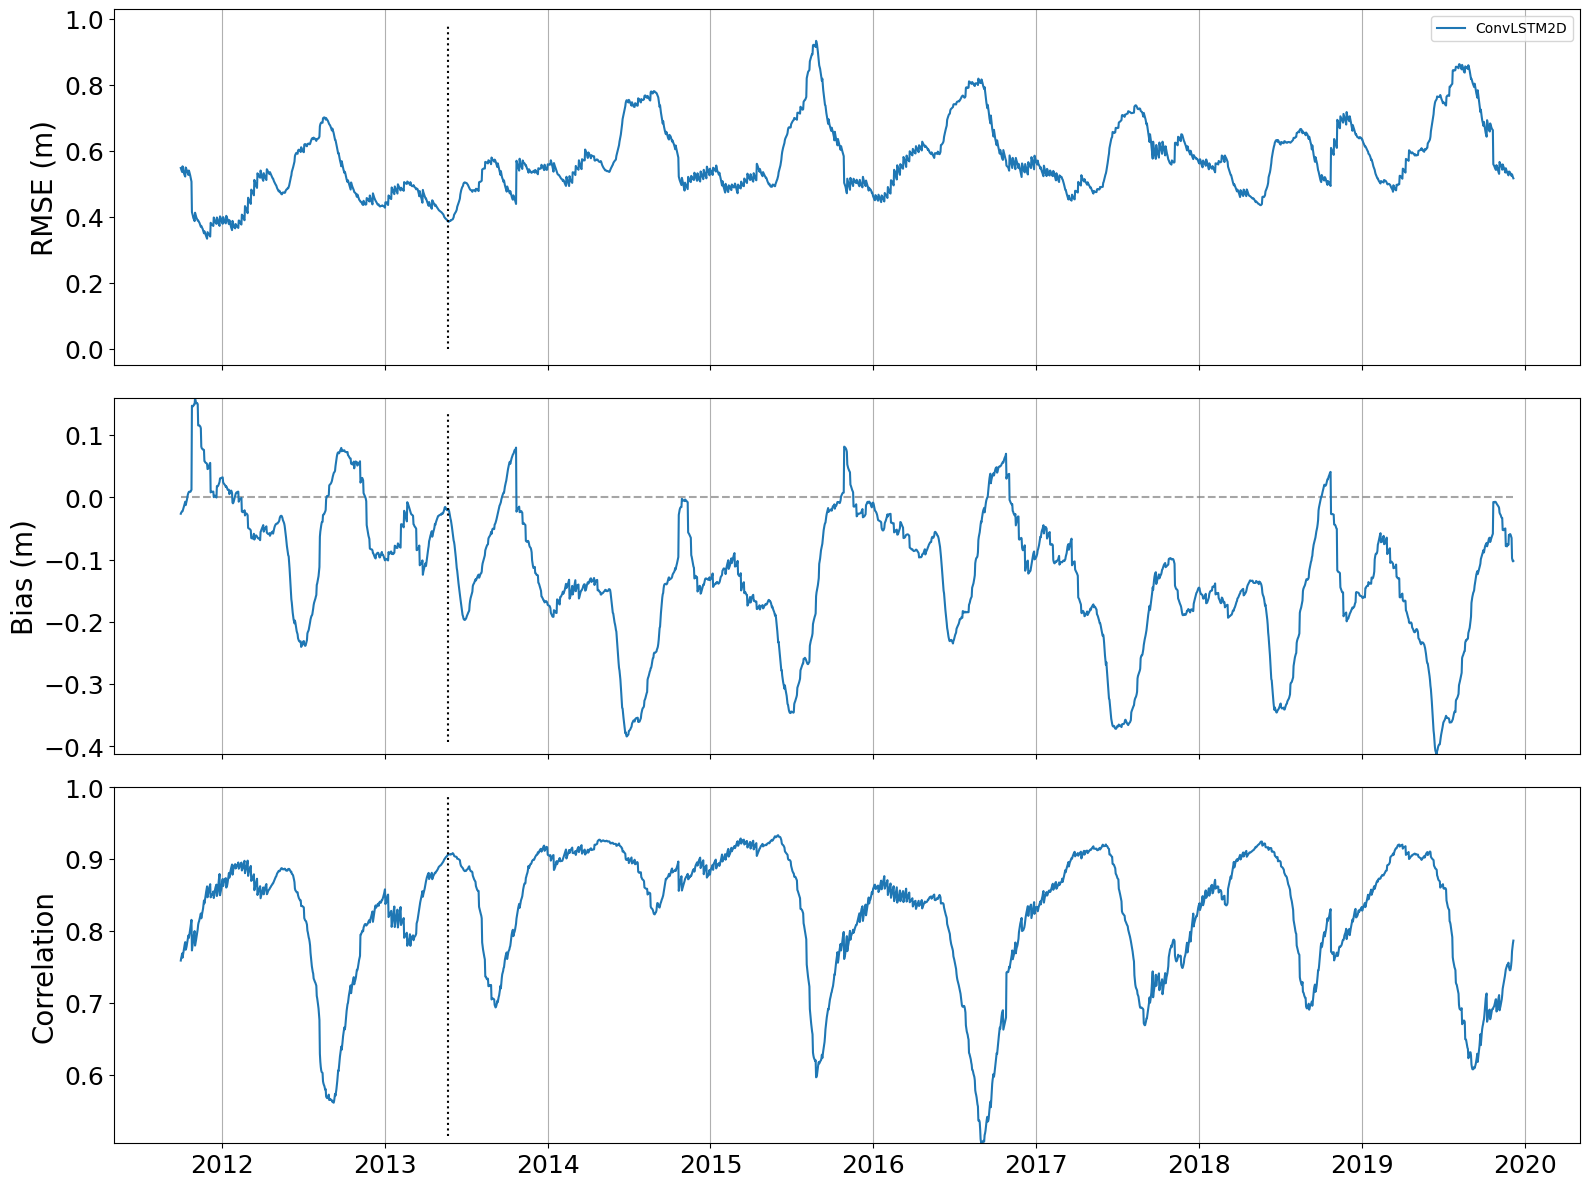

In [66]:
draw_rmse_bias_corr(rmse, bias, corr, chrono, ntest, showfig=True, savefig=False)

In [65]:
from src.utils import modif_plot

def draw_rmse_bias_corr(rmse, bias, corr, chrono, ntest, rootdir=None, fig_dir=None, savefig=True, showfig=False):
    '''Draw time series of RMSE and bias for the following data:
                - TOPAZ 4b Free Run
                - baseline
                - ML reconstructed
                
    Parameters:
    -----------
        model     : class SITCorrected
                
    '''

    fig, ax = plt.subplots(ncols=1, nrows=3,figsize=(16,12))

   # chrono = chrono

    ax[0].plot(chrono, rmse, label='ConvLSTM2D')
#     ax[0].plot(chrono, model.RMSE_bl_t, '#5cad47', label='baseline') # alpha=0.5
#     ax[0].plot(model.chrono, model.RMSE_ml_t, label=f'{model.name}')
    ax[0].plot([chrono.iloc[ntest]]*2,[0.0, 0.98], ':k')  # label='train limit'
    ax[0].legend()
    ax[0].set_xticklabels('')
    ax[0].set_ylabel(f'RMSE (m)')
    ax[0].xaxis.grid()

    ax[1].plot([chrono.iloc[0], chrono.iloc[-1]], [0]*2, '--', c='grey', alpha=.7)
    ax[1].plot(chrono, bias)
#     ax[1].plot(chrono, model.bias_bl, '#5cad47', label='baseline') # , alpha=0.5)
#     ax[1].plot(model.chrono, model.bias_ml, label=f'{model.name}')
    
    
    min_bias, max_bias = np.nanmin(bias), np.nanmax(bias)
    
    ax[1].plot([chrono.iloc[ntest]]*2,[min_bias+0.02, max_bias-0.02], ':k')
    ax[1].set_ylim([min_bias, max_bias])
    ax[1].set_ylabel(f'Bias (m)')
    ax[1].xaxis.grid()
    ax[1].set_xticklabels('')
    
    ax[2].plot(chrono, corr)
#     ax[2].plot(chrono, model.corr_bl_t, '#5cad47')
#     ax[2].plot(model.chrono, model.corr_ml_t)
    
    min_corr = np.nanmin(corr)

#     max_corr = np.nanmax([np.nanmax(model.corr_na_t),
#                           np.nanmax(model.corr_bl_t), 
#                           np.nanmax(model.corr_ml_t)])
    ax[2].plot([chrono.iloc[ntest]]*2,[min_corr+0.01, .99], ':k')
    
    ax[2].set_ylim([min_corr, 1])
    ax[2].set_ylabel(f'Correlation')
    ax[2].xaxis.grid()
    
    
    plt.xticks(rotation= -25)

    modif_plot.resize(fig, s=18)
    fig.tight_layout()

    if savefig:
        filename = f'ML_RMSE_bias_corr_01.png'
        plt.savefig(f"{rootdir}{fig_dir}{filename}")
        print(f"{rootdir}{fig_dir}{filename}")
    
    if showfig:
        plt.show()
        
    plt.close()